In [2]:
#Import packages
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

## The data analysis below uses Airbnb data of San Francisco in March 2018

In [71]:
#Read SF listings from March 2018 csv file to a Pandas DataFrame
url_listing = 'http://data.insideairbnb.com/united-states/ca/san-francisco/2018-03-04/data/listings.csv.gz'
df_listing = pd.read_csv(url_listing, sep=',')

In [4]:
#Read SF listing summary csv into a Pandas DataFrame
url = 'http://data.insideairbnb.com/united-states/ca/san-francisco/2018-03-04/visualisations/listings.csv'
df = pd.read_csv(url, sep=',')

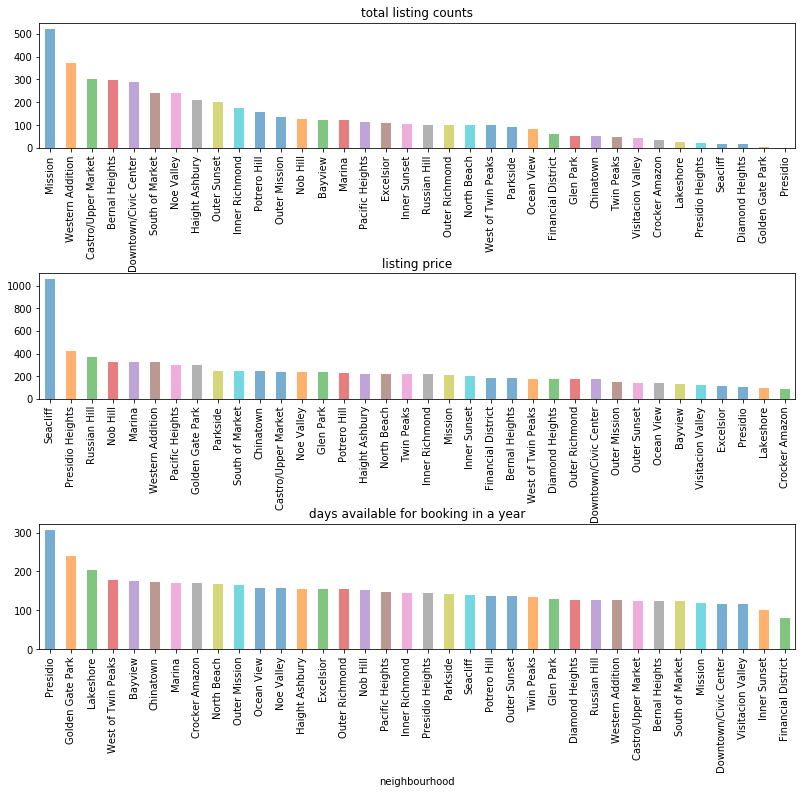

In [5]:
#Count the total listings in each neighbourhood
nh_counts = df['neighbourhood'].value_counts(dropna=False)
plt.subplot(3,1,1)
nh_counts.plot(kind='bar', title='total listing counts', alpha = 0.6, figsize=(12,3))

#Get the average price of listings in each neighbourhood
nh_price = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
plt.subplot(3,1,2)
nh_price.plot(kind='bar', title = 'listing price', alpha = 0.6, figsize=(12,3))

# This shows the popularity of different neighbourhoods in San Francisco
nh_avail = df.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=False)
plt.subplot(3,1,3)
nh_avail.plot(kind='bar', title = 'days available for booking in a year', alpha = 0.6, figsize=(12,3))

plt.subplots_adjust(left=0.125, bottom=0.1, right=1, top=3, wspace=None, hspace=1)

In [6]:
#Load geodata with geometry information of the neighbourhoods in San Francisco
geo_file = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/neighbourhoods.geojson'
with open(geo_file) as f:
    geodata = json.load(f)
    
#Create a GeoDataFrame from geodata    
nh_gdf = GeoDataFrame.from_features(geodata)

#Delete the empty column 'neighbourhood_group'
del nh_gdf['neighbourhood_group']

#Set the GeoDataFrame's index to 'neighbourhood'
nh_gdf = nh_gdf.set_index('neighbourhood')

In [7]:
#Combine the GeoDataFrame nh_gdf with other neighbourhood dfs.
neighbourhood_gdf = pd.concat([nh_gdf, nh_counts, nh_price, nh_avail], axis=1, join='outer', sort=True)
neighbourhood_gdf = neighbourhood_gdf.dropna(how='any')
neighbourhood_gdf = neighbourhood_gdf.rename(index=str, columns={'neighbourhood':'total listings'})
neighbourhood_gdf.head()

,geometry,total listings,price,availability_365
Bayview,"(POLYGON ((-122.388108 37.747803, -122.3881 37...",123.0,127.284553,175.975610
Bernal Heights,"(POLYGON ((-122.428255 37.731785, -122.428147 ...",299.0,178.662207,123.789298
Castro/Upper Market,"(POLYGON ((-122.446438 37.761036, -122.446408 ...",301.0,238.920266,124.039867
Chinatown,"(POLYGON ((-122.408767 37.790163, -122.408797 ...",51.0,241.686275,172.627451
Crocker Amazon,"(POLYGON ((-122.42085 37.708335, -122.423878 3...",35.0,88.742857,170.685714


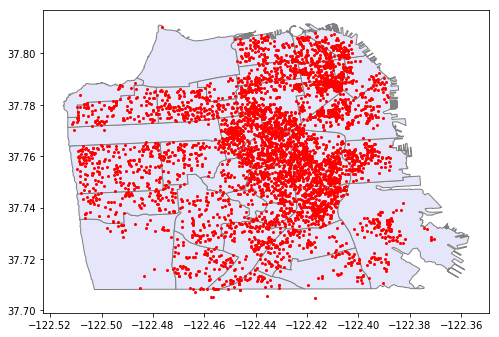

In [8]:
loc = zip(df_listing['longitude'], df_listing['latitude'])
geometry = [Point(xy) for xy in loc]
crs = {'init': 'epsg:4269'}
listing_geo = gpd.GeoDataFrame(df_listing, crs=crs, geometry=geometry)
base = neighbourhood_gdf.plot(color='lavender', edgecolor='grey', figsize=(8,8))
listing_geo.plot(ax=base, marker='o', color='red', markersize = 4)
plt.show()

### The map above shows the location of the Airbnb units in San Francisco. As the maps above show, Airbnb units appear to be concentrated in the northern and eastern neighborhoods of the city.

Text(0.5,1,'Number of listings by neighbourhood')

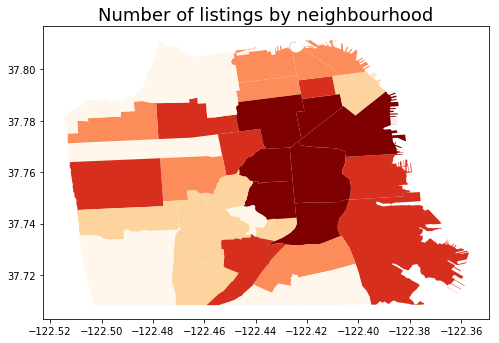

In [9]:
neighbourhood_gdf.plot(column='total listings', cmap='OrRd', figsize=(8,8), scheme='quantiles')
plt.title('Number of listings by neighbourhood', {'fontsize': 18})

### This map demonstrates that most listings are concentrated in core neighborhoods that are close to Market Street.

Text(0.5,1,'Average listing price per night by neighbourhood')

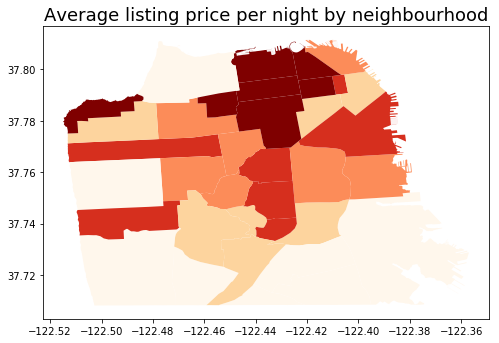

In [10]:
neighbourhood_gdf.plot(column='price', cmap='OrRd', figsize=(8,8), scheme='quantiles')
plt.title('Average listing price per night by neighbourhood', {'fontsize': 18})

### This map shows that most expensive listings are concentrated in north of Market Street and Seacliff area.

Text(0.5,1,'Average days available for booking in one year')

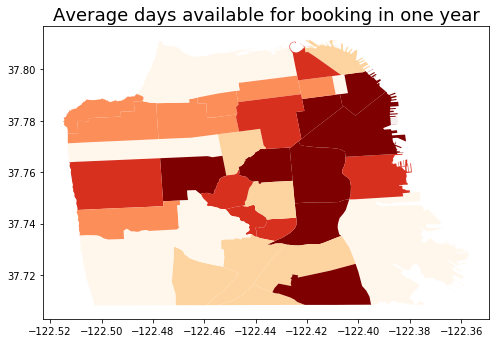

In [11]:
#Use a reverse cmap to indicate the availability_365, because the less available the listing, the more popular it is.
neighbourhood_gdf.plot(column='availability_365', cmap='OrRd_r', figsize=(8,8), scheme='quantiles')
plt.title('Average days available for booking in one year', {'fontsize': 18})

### This map shows that the most popular neighbourhoods are those areas relatively cheap, but still close to the core neighbourhoods around Market Street. The most expensive neighbourhoods are relatively less desirable for a home stay with Airbnb

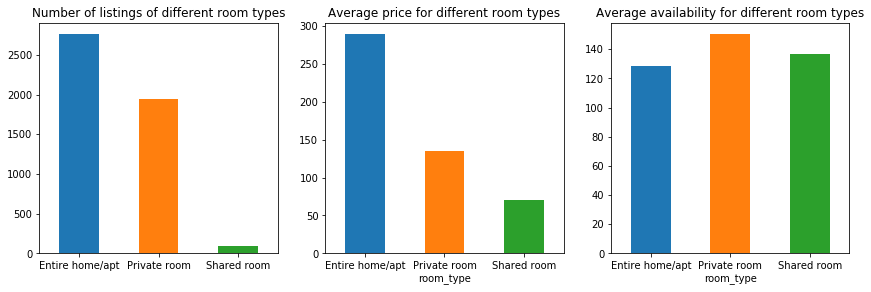

In [81]:
df_roomtype = df['room_type'].value_counts(dropna=False)
plt.subplot(1,3,1)
df_roomtype.plot(kind='bar',title = 'Number of listings of different room types', rot=0)
plt.subplot(1,3,2)
df.groupby('room_type')['price'].mean().plot(kind='bar', title = 'Average price for different room types', rot=0)
plt.subplot(1,3,3)
df.groupby('room_type')['availability_365'].mean().plot(kind='bar', title = 'Average availability for different room types', rot=0)
plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2, hspace=None)

### The plots above show that most people rent the entire home/apt out, and less people rent one of the rooms in their houses, and very few people share their rooms with strangers. The entire home types are most expensive, followed by private room and the shared rooms are the cheapest. The popularity are quite similar among different room types.

In [22]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

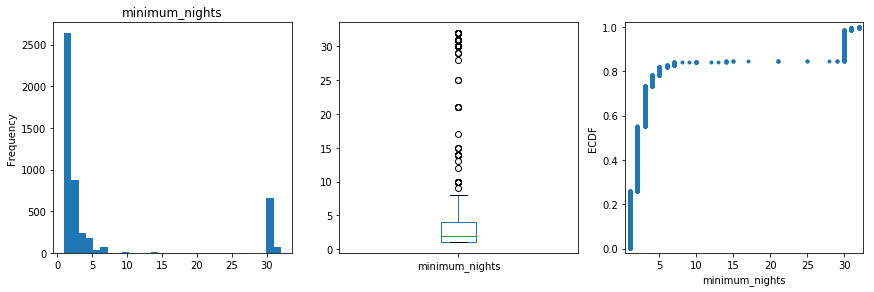

In [25]:
plt.subplot(1,3,1)
df_listing[df_listing.minimum_nights<50]['minimum_nights'].plot(kind='hist', bins=30, title = 'minimum_nights')

plt.subplot(1,3,2)
df_listing[df_listing['minimum_nights']<50]['minimum_nights'].plot(kind='box')

#Empirical Cumulative Distribution Function
x_mn, y_mn = ecdf(df_listing[df_listing.minimum_nights<50]['minimum_nights'])
plt.subplot(1,3,3)
plt.plot(x_mn, y_mn, marker = '.', linestyle = 'none')
plt.xlabel('minimum_nights')
plt.ylabel('ECDF')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2)

### The above plots show that most people did not require a minimum nights more than one night. And there are over 500 listings have requirements of a minimum night of 30 days. The listings with more than 30 day minimum night requirements are outliners.

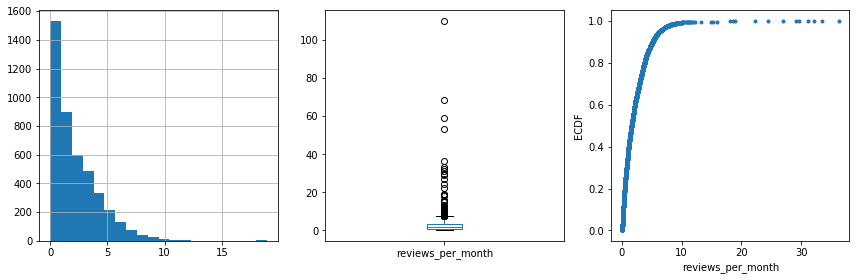

In [34]:
plt.subplot(1,3,1)
df_listing[df_listing.reviews_per_month<20]['reviews_per_month'].hist(bins=20)

plt.subplot(1,3,2)
df_listing['reviews_per_month'].plot(kind='box')

#Empirical Cumulative Distribution Function
x_rv, y_rv = ecdf(df_listing[df_listing.reviews_per_month <50]['reviews_per_month'])
plt.subplot(1,3,3)
plt.plot(x_rv, y_rv, marker = '.', linestyle = 'none')
plt.xlabel('reviews_per_month')
plt.ylabel('ECDF')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2)

### The plots show the listings with more than 10 reviews per month are outliers. And the listings with more than 30 reviews per month do not make sense and are impossible in reality.

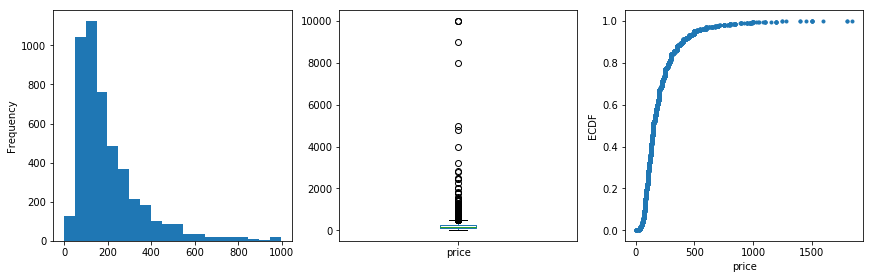

In [60]:
# Visualize the distribution of price
plt.subplot(1,3,1)
df[df['price']<1000]['price'].plot(kind='hist', bins=20)
plt.subplot(1,3,2)
df['price'].plot(kind='box')
#Empirical Cumulative Distribution Function
x_pr, y_pr = ecdf(df[df['price']<2000]['price'])
plt.subplot(1,3,3)
plt.plot(x_pr, y_pr, marker = '.', linestyle = 'none')
plt.xlabel('price')
plt.ylabel('ECDF')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2)

In [61]:
df.price.median()

150.0

### The plots show that the prices of about 99% listings are under 1000 USD per night. The median price a night in SF is 150 USD. The listings with more than 1000 USD are outliers statistically but it does not necessarily mean these listings do not exit.

In [72]:
#Remove the dollar sign and convert the 'price' column to numeric dtype.
df_listing['price'] = df_listing.price.apply(lambda x: x.replace('$', ''))
df_listing['price'] = pd.to_numeric(df_listing['price'], errors='coerce')

In [77]:
import seaborn as sns

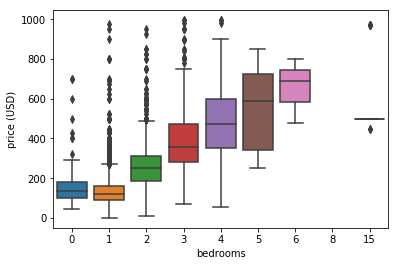

In [79]:
_ = sns.boxplot(x = 'bedrooms', y = 'price', data = df_listing)

# Label the axes
_ = plt.xlabel('bedrooms')
_ = plt.ylabel('price (USD)')

### The plot above shows that the more beds of a listing, the more expensive. There are only one listing with 15 bedrooms. There is not much difference between a one bedroom apt and a studio.

In [109]:
df_listing[df_listing.reviews_per_month > 7]['availability_90'].max()


79

##### Among the most popular listings in SF (shown by reviews_per_month greater than 7), the max of availabile days for booking in the next 90 days is 79 days. However, there are many listings with zero reviews and they are fully booked in the next 90 days. This is because some hosts blacked out half a year or a whole year from their calendars, not because these listings are all sold out in the next 90 days. The common sense is you can still book your stay for even the most popular listings in three months.

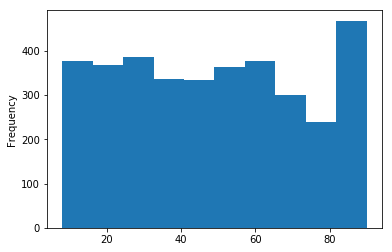

In [115]:
df_listing[df_listing['availability_90'] > 7]['availability_90'].plot(kind='hist',bins=10)

In [121]:
#Since there are blackout dates created by the hosts, I adjusted the dataframe by filtering the 'availability_90' greater than
#7 days to analyze factors related to the availability of the listings. 
df_clean = df_listing[(df_listing['availability_90'] > 7) & (df_listing['minimum_nights']<=60)]
df_clean.shape

(3543, 96)

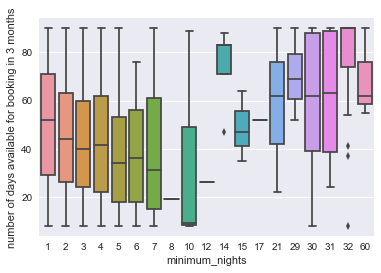

In [126]:
_ = sns.boxplot(x = 'minimum_nights', y = 'availability_90', data=df_clean)
# Label the axes
_ = plt.xlabel('minimum_nights')
_ = plt.ylabel('number of days available for booking in 3 months')
# Show the plot
plt.show()

### The plot above shows that listings with a minimum of more than 10 nights stay requirement are relatively less popular than those with less than 10 nights minimum stay. And among the listings with a less than a week of minimum nights stay requirement, the more minimum nights the host requires the guests to stay, the more popular the listing is. 

Text(0.5,1,'Cancellation policy')

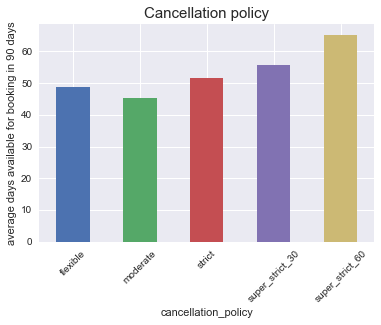

In [171]:
df_clean.groupby('cancellation_policy')['availability_90'].mean().plot(kind='bar', rot=45)
plt.ylabel('average days available for booking in 90 days')
plt.title('Cancellation policy', fontsize= 15)

### This plot shows that a flexible or strict cancellation policy does not significantly affect the popularity of a listing. A stricter cancellation policy decrease the booking rate a little bit. And setting a moderate cancellation policy helps with the booking rate.

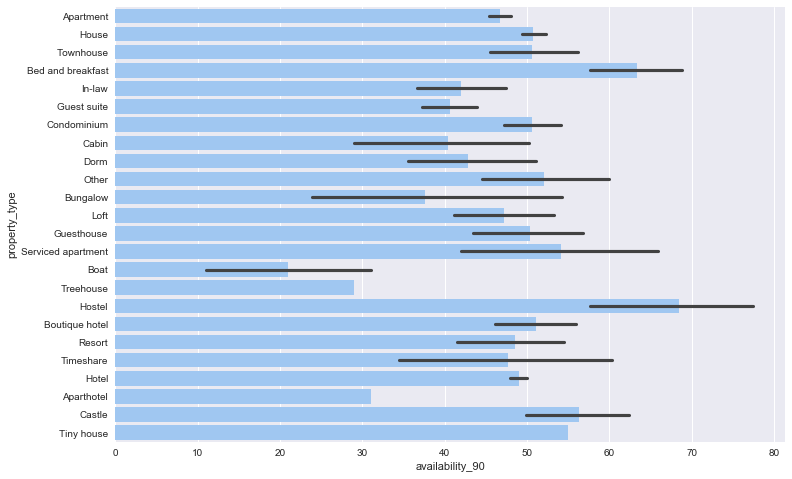

In [203]:
plt.figure(figsize=(12,8))
sns.set_color_codes('pastel')
sns.barplot(x='availability_90', y='property_type', data = df_clean, color="b")

### The barplot shows that the most popular property types are boat, treehouse, apartment hotel and bungalow, which means unique and fancy properties are very attractive and having high occupancy rates.